# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [264]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns

In [265]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [266]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

def show_pred(y_test, y_pred, xlabel):
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, y_test)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    plt.xlabel(xlabel)
    plt.ylabel("True Sales Hl")

    plt.show()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:    
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [267]:
DATASET_NAME = 'off-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [268]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays=workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [269]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
16474,01015,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,1510.000000,9971.780620,1606.096830,2954.9000,5282.3000,14068.4000,1001.3000,1805.0000,3450.3998
16475,01016,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,197.619048,NaN,147.586571,451.2816,371.9232,558.9936,130.1256,159.1128,410.0324
16476,01022,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,NaN,283.333333,84.234569,64.6800,229.0200,313.9950,99.3300,72.4900,99.5995
16477,01027,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,NaN,NaN,7.246267,11.7216,20.9088,38.4120,6.6528,3.9600,6.6523
16478,01041,CLEAR BEER,RB,CZ,2018,1,4,5.1125,3.164286,1.0625,1.635714,0.925,2.042857,False,342.857143,678.853185,221.337900,261.0400,1491.2400,1327.8800,447.4800,410.4400,447.1999


In [270]:
data = reduce_mem_usage(data)

Mem. usage decreased to  2.21 Mb (59.5% reduction)


In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30896 entries, 16474 to 47369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          30896 non-null  object 
 1   ProductGroup      30896 non-null  object 
 2   PrimaryPack       30896 non-null  object 
 3   Country           30896 non-null  object 
 4   Year              30896 non-null  int16  
 5   Week              30896 non-null  int8   
 6   NumberWorkdays    30896 non-null  int8   
 7   AvgTemp           30896 non-null  float16
 8   PrevWeekAvgTemp   30896 non-null  float16
 9   AvgRain           30896 non-null  float16
 10  PrevWeekAvgRain   30896 non-null  float16
 11  AvgSun            30896 non-null  float16
 12  PrevWeekAvgSun    30896 non-null  float16
 13  IsLockdown        30896 non-null  bool   
 14  PdtHl             24466 non-null  float16
 15  PrevWeekPdtHl1    24145 non-null  float16
 16  BgtHl             25763 non-null  fl

In [272]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,30896.000000,30896.000000,30896.000000,3.089600e+04,3.089600e+04,30896.000000,30896.000000,3.089600e+04,3.089600e+04,2.446600e+04,2.414500e+04,25763.0000,30896.00000,2.982600e+04,2.958500e+04,25905.00000,22975.000,2.888600e+04
mean,2019.228314,25.319556,4.776735,inf,inf,1.629883,1.612305,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
std,0.976392,15.192791,0.505094,7.687500e+00,7.691406e+00,1.675781,1.650391,3.095703e+00,3.113281e+00,inf,inf,inf,inf,inf,inf,inf,inf,inf
min,2018.000000,1.000000,2.000000,-8.281250e+00,-8.281250e+00,0.000000,0.000000,1.428223e-01,1.428223e-01,5.279541e-02,5.279541e-02,-28.5625,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000,6.210327e-02
25%,2018.000000,12.000000,5.000000,3.277344e+00,3.277344e+00,0.399902,0.378662,2.214844e+00,2.185547e+00,2.859375e+01,2.884375e+01,47.1875,22.00000,2.479688e+01,2.526562e+01,38.53125,51.750,3.300000e+01
50%,2019.000000,24.000000,5.000000,9.960938e+00,9.835938e+00,1.062500,1.062500,5.007812e+00,5.007812e+00,1.250000e+02,1.250000e+02,186.7500,118.96875,1.244375e+02,1.250000e+02,165.12500,185.625,1.467500e+02
75%,2020.000000,39.000000,5.000000,1.679688e+01,1.679688e+01,2.365234,2.365234,7.265625e+00,7.265625e+00,4.840000e+02,4.795000e+02,677.0000,536.50000,5.560000e+02,5.555000e+02,641.50000,679.000,6.130000e+02
max,2021.000000,53.000000,5.000000,2.581250e+01,2.581250e+01,7.957031,7.957031,1.386719e+01,1.386719e+01,2.523200e+04,2.523200e+04,15544.0000,24288.00000,2.428800e+04,2.428800e+04,24288.00000,23152.000,2.486400e+04


## Missing Values

In [273]:
data.isna().sum()

SkuShort            0   
ProductGroup        0   
PrimaryPack         0   
Country             0   
Year                0   
Week                0   
NumberWorkdays      0   
AvgTemp             0   
PrevWeekAvgTemp     0   
AvgRain             0   
PrevWeekAvgRain     0   
AvgSun              0   
PrevWeekAvgSun      0   
IsLockdown          0   
PdtHl               6430
PrevWeekPdtHl1      6751
BgtHl               5133
SalesHl             0   
PrevWeekSalesHl1    1070
PrevWeekSalesHl2    1311
PrevYearSalesHl1    4991
PrevYearSalesHl2    7921
OldPredSalesHl      2010
dtype: int64

## Data Visualizations

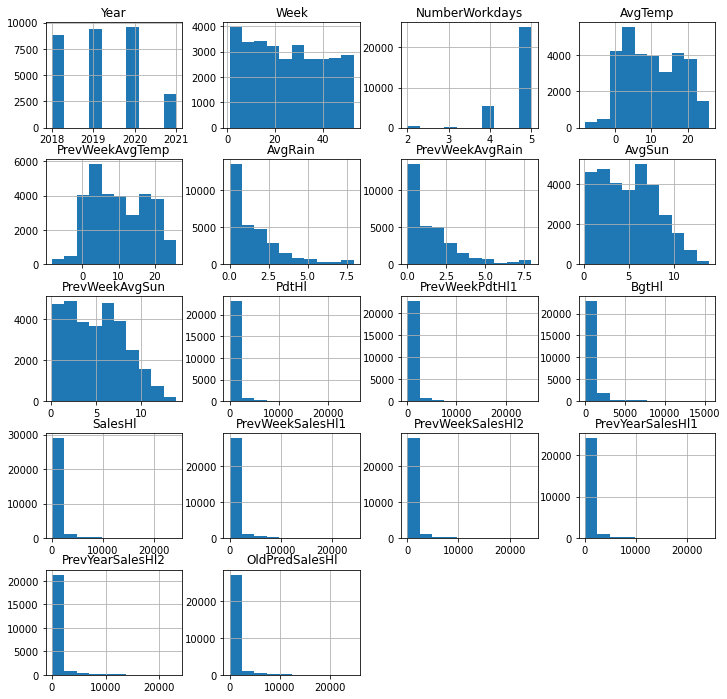

In [274]:
data.hist(figsize=[12,12])
plt.show()

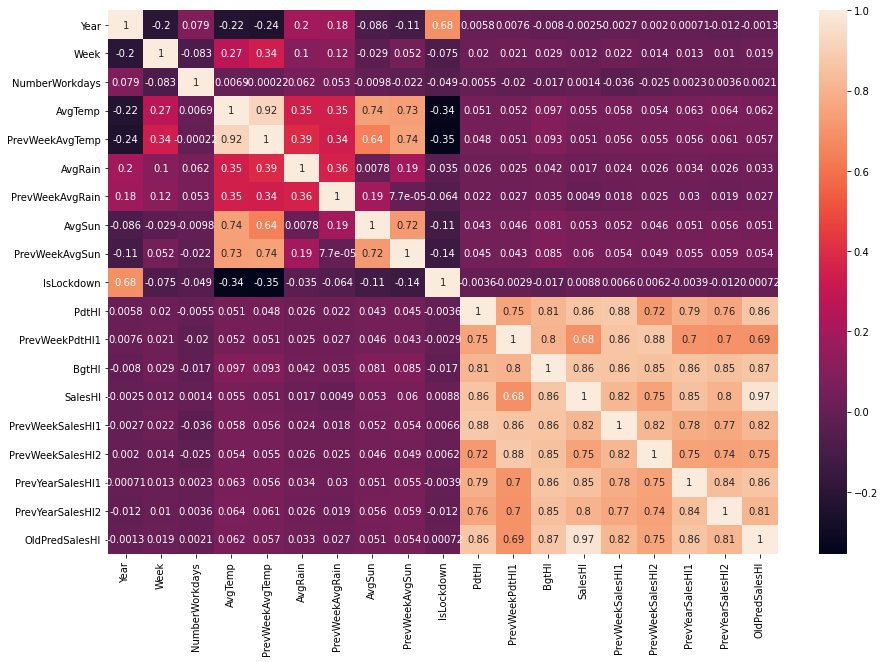

In [275]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

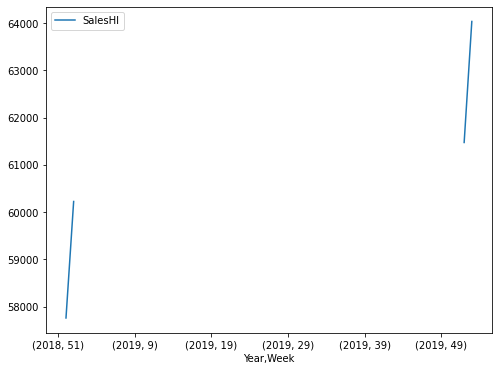

In [276]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

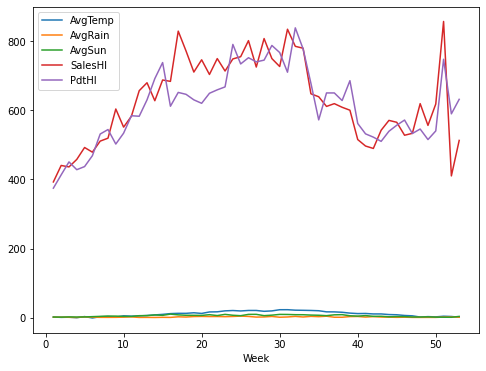

In [277]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

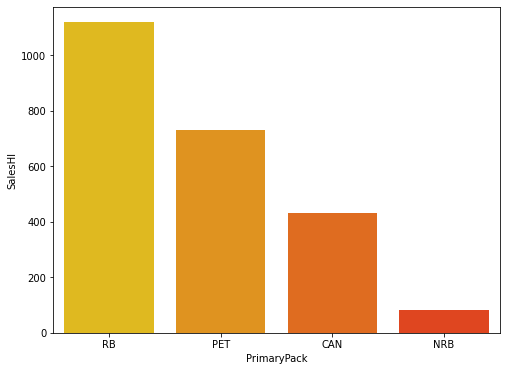

In [278]:
plt.figure(figsize=(8,6))
g_pps = data.groupby('PrimaryPack')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('PrimaryPack')
axis.set_ylabel('SalesHl')

plt.show()

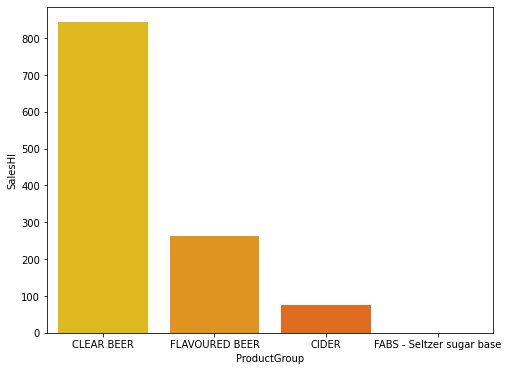

In [279]:
plt.figure(figsize=(8,6))
g_pgs = data.groupby('ProductGroup')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pgs.index, y=g_pgs, palette='autumn_r')
axis.set_xlabel('ProductGroup')
axis.set_ylabel('SalesHl')
plt.show()

In [280]:
# ordinals = ['Week','NumberWorkdays','AvgTemp','AvgRain','AvgSun','PdtHl','BgtHl','PrevWeekSalesHl1','PrevYearSalesHl1']

# fig, ax = plt.subplots(3, 5, figsize=(15, 10))
# fig.tight_layout()
# ax = iter(ax.flatten())
# for feat in ordinals:
#     dataplot = data[[feat, 'SalesHl']]
#     sns.boxplot(x=feat, y='SalesHl', data=dataplot, ax=next(ax))

In [281]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.973277
BgtHl,0.863480
PdtHl,0.858273
PrevYearSalesHl1,0.851647
PrevWeekSalesHl1,0.816765
PrevYearSalesHl2,0.803885
PrevWeekSalesHl2,0.746771
PrevWeekPdtHl1,0.682947
PrevWeekAvgSun,0.059527


## Skewness and Kurtesis

In [282]:
data.skew()

SkuShort            0.555835
Year                0.193431
Week                0.130756
NumberWorkdays     -2.718235
AvgTemp             inf     
PrevWeekAvgTemp     inf     
AvgRain             inf     
PrevWeekAvgRain     inf     
AvgSun              inf     
PrevWeekAvgSun      inf     
IsLockdown          1.272864
PdtHl               inf     
PrevWeekPdtHl1      inf     
BgtHl               inf     
SalesHl             inf     
PrevWeekSalesHl1    inf     
PrevWeekSalesHl2    inf     
PrevYearSalesHl1    inf     
PrevYearSalesHl2    inf     
OldPredSalesHl      inf     
dtype: float64

In [283]:
data.kurt()

SkuShort           -0.753739
Year               -1.048710
Week               -1.215158
NumberWorkdays      9.092669
AvgTemp            NaN      
PrevWeekAvgTemp    NaN      
AvgRain            NaN      
PrevWeekAvgRain    NaN      
AvgSun             NaN      
PrevWeekAvgSun     NaN      
IsLockdown         -0.379842
PdtHl              NaN      
PrevWeekPdtHl1     NaN      
BgtHl              NaN      
SalesHl            NaN      
PrevWeekSalesHl1   NaN      
PrevWeekSalesHl2   NaN      
PrevYearSalesHl1   NaN      
PrevYearSalesHl2   NaN      
OldPredSalesHl     NaN      
dtype: float64

## Create X, y

In [284]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'ProductGroup','PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun' ] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun' 'BgtHl',

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [285]:
X['NextWeek'] = X['Week']+1
X['PrevWeek'] = X['Week']-1

X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

X = X.drop(['NextWeek', 'PrevWeek', 'WeekPrev', 'WeekNext'], axis=1)
X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
X

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,01015,RB,CZ,2018,1,4,5.113281,1.06250,0.924805,False,1510.00000,9968.00000,1606.000000,5284.000000,14072.000000,1001.500000,1805.000000,5.0,5.0
1,01016,RB,CZ,2018,1,4,5.113281,1.06250,0.924805,False,197.62500,NaN,147.625000,372.000000,559.000000,130.125000,159.125000,5.0,5.0
2,01022,RB,CZ,2018,1,4,5.113281,1.06250,0.924805,False,NaN,283.25000,84.250000,229.000000,314.000000,99.312500,72.500000,5.0,5.0
3,01027,RB,CZ,2018,1,4,5.113281,1.06250,0.924805,False,NaN,NaN,7.246094,20.906250,38.406250,6.652344,3.960938,5.0,5.0
4,01041,RB,CZ,2018,1,4,5.113281,1.06250,0.924805,False,342.75000,679.00000,221.375000,1491.000000,1328.000000,447.500000,410.500000,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30891,13774,CAN,SK,2021,19,5,14.109375,5.59375,5.882812,True,NaN,NaN,19.562500,1.425781,7.921875,1.742188,NaN,5.0,5.0
30892,16375,NRB,SK,2021,19,5,14.109375,5.59375,5.882812,True,65.62500,26.03125,NaN,149.000000,134.125000,NaN,NaN,5.0,5.0
30893,16475,NRB,SK,2021,19,5,14.109375,5.59375,5.882812,True,59.59375,21.59375,NaN,114.812500,109.000000,NaN,NaN,5.0,5.0
30894,18076,CAN,SK,2021,19,5,14.109375,5.59375,5.882812,True,77.93750,197.25000,164.875000,126.625000,267.750000,142.500000,71.875000,5.0,5.0


## LabelEncoder

In [286]:
Country_mapping = {"CZ": 1, "SK": 2}
PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

el = LabelEncoder()
X.SkuShort = el.fit_transform(X.SkuShort)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,0,3,1,2018,1,4,5.113281,1.0625,0.924805,False,1510.000,9968.00,1606.000000,5284.00000,14072.00000,1001.500000,1805.000000,5.0,5.0
1,1,3,1,2018,1,4,5.113281,1.0625,0.924805,False,197.625,NaN,147.625000,372.00000,559.00000,130.125000,159.125000,5.0,5.0
2,2,3,1,2018,1,4,5.113281,1.0625,0.924805,False,NaN,283.25,84.250000,229.00000,314.00000,99.312500,72.500000,5.0,5.0
3,4,3,1,2018,1,4,5.113281,1.0625,0.924805,False,NaN,NaN,7.246094,20.90625,38.40625,6.652344,3.960938,5.0,5.0
4,6,3,1,2018,1,4,5.113281,1.0625,0.924805,False,342.750,679.00,221.375000,1491.00000,1328.00000,447.500000,410.500000,5.0,5.0


## Imputer

In [287]:
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [288]:
si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)

si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Adding a New Feature

In [289]:
#round weather
X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
X.AvgRain = X.AvgRain.round(1)#.astype('int64')
X.AvgSun = X.AvgSun.round(1)#.astype('int64')

In [290]:
#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

# X['adsfa'] = X['PrevWeekSalesHl1'] / X['PrevYearSalesHl1']
# X['adsfa'] = X['adsfa'].round(2).astype('float16')
# X['SalesPerPredYear'] = X['PrevWeekSalesHl1'].divide(X['PrevYearSalesHl1'], fill_value=0) #dataset['PrevWeekSalesHl1'] / dataset['PrevWeekPdtHl1']
# X['SalesPerPredYear'] = X['SalesPerPredYear'].replace([np.inf, -np.inf, np.nan], 0)

# X['SalesPerPdt'] = X['PrevWeekSalesHl1'].divide(X['PrevWeekPdtHl1'], fill_value=0) #dataset['PrevWeekSalesHl1'] / dataset['PrevWeekPdtHl1']
# X['SalesPerPdt'] = X['SalesPerPdt'].replace([np.inf, -np.inf, np.nan], 0)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl,SalesPerPdt
0,0.0,3.0,1.0,2018.0,1.0,4.0,5.1,1.1,0.9,0.0,1510.000,9968.00,1606.000000,5284.00000,14072.00000,1001.500000,1805.000000,5.0,5.0,9678.0,1403.2,5540.6,0.530096
1,1.0,3.0,1.0,2018.0,1.0,4.0,5.1,1.1,0.9,0.0,197.625,0.00,147.625000,372.00000,559.00000,130.125000,159.125000,5.0,5.0,465.5,144.6,305.1,0.000000
2,2.0,3.0,1.0,2018.0,1.0,4.0,5.1,1.1,0.9,0.0,0.000,283.25,84.250000,229.00000,314.00000,99.312500,72.500000,5.0,5.0,271.5,85.9,178.7,0.808473
3,4.0,3.0,1.0,2018.0,1.0,4.0,5.1,1.1,0.9,0.0,0.000,0.00,7.246094,20.90625,38.40625,6.652344,3.960938,5.0,5.0,29.7,5.3,17.5,0.000000
4,6.0,3.0,1.0,2018.0,1.0,4.0,5.1,1.1,0.9,0.0,342.750,679.00,221.375000,1491.00000,1328.00000,447.500000,410.500000,5.0,5.0,1409.5,429.0,919.2,2.195876


In [291]:
X.tail()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl,SalesPerPdt
30891,232.0,1.0,2.0,2021.0,19.0,5.0,14.1,5.6,5.9,1.0,0.00000,0.00000,19.562500,1.425781,7.921875,1.742188,740.013552,5.0,5.0,4.7,370.9,187.8,0.000000
30892,248.0,4.0,2.0,2021.0,19.0,5.0,14.1,5.6,5.9,1.0,65.62500,26.03125,676.606571,149.000000,134.125000,698.175027,740.013552,5.0,5.0,141.6,719.1,430.3,5.723890
30893,250.0,4.0,2.0,2021.0,19.0,5.0,14.1,5.6,5.9,1.0,59.59375,21.59375,676.606571,114.812500,109.000000,698.175027,740.013552,5.0,5.0,111.9,719.1,415.5,5.316932
30894,254.0,1.0,2.0,2021.0,19.0,5.0,14.1,5.6,5.9,1.0,77.93750,197.25000,164.875000,126.625000,267.750000,142.500000,71.875000,5.0,5.0,197.2,107.2,152.2,0.641952
30895,260.0,1.0,2.0,2021.0,19.0,5.0,14.1,5.6,5.9,1.0,55.28125,138.12500,83.375000,80.500000,197.500000,56.156250,47.875000,5.0,5.0,139.0,52.0,95.5,0.582805


## Split train, test

In [292]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)

#X = X.drop(['Year'], axis=1)
# X['Year'] = (X['Year']-1900).astype(int)
 
X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]
y_train = y_train.round(-1)

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl,SalesPerPdt
29172,0.0,3.0,1.0,2021.0,10.0,5.0,2.3,0.9,3.4,1.0,7360.0,5216.000000,6848.000000,8264.000000,4304.000000,9072.000000,7284.000000,5.0,5.0,6284.0,8178.0,7231.0,1.584356
29173,1.0,3.0,1.0,2021.0,10.0,5.0,2.3,0.9,3.4,1.0,303.0,331.500000,413.750000,109.937500,230.625000,175.125000,157.125000,5.0,5.0,170.3,166.1,168.2,0.331637
29174,4.0,3.0,1.0,2021.0,10.0,5.0,2.3,0.9,3.4,1.0,0.0,0.000000,7.050781,9.820312,10.453125,5.941406,17.421875,5.0,5.0,10.1,11.7,10.9,0.000000
29175,6.0,3.0,1.0,2021.0,10.0,5.0,2.3,0.9,3.4,1.0,0.0,14.289062,450.500000,519.000000,364.750000,168.500000,266.750000,5.0,5.0,441.9,217.6,329.8,36.321487
29176,7.0,3.0,1.0,2021.0,10.0,5.0,2.3,0.9,3.4,1.0,252.0,0.000000,676.606571,864.000000,640.711353,698.175027,740.013552,5.0,5.0,752.4,719.1,735.7,0.000000


## Scaler

In [293]:
#scaler = MinMaxScaler() #0.8361
#scaler = MaxAbsScaler() #0.8335
scaler = StandardScaler() #0.8381
#scaler = RobustScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# y_train = np.log1p(y_train)
# X_test = np.log1p(X_test)

## Regressor

In [294]:

# model = linear_model.Ridge(random_state=0) 

# param_grid = dict(solver=['auto', 'svd','cholesky','sparse_cg', 'sag', 'saga'], max_iter=[300], normalize=[True, False], fit_intercept=[True,False], alpha=[1, 0.9, 1.1])

# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)


In [295]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) 
#model = ensemble.ExtraTreesRegressor(n_jobs=3) 
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

# #option CV
#NOT model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
#NOT model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
#model = linear_model.OrthogonalMatchingPursuit() 
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True)
# model = linear_model.RANSACRegressor(max_trials=500)
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True)
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#model = linear_model.PassiveAggressiveRegressor(epsilon=0.001, fit_intercept=True, loss='epsilon_insensitive', max_iter=1000, n_iter_no_change= 5, shuffle=True, validation_fraction=0.1, warm_start=True)

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#model = svm.LinearSVR()


# mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)

# xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# # lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)
# model = LGBMRegressor() 

# model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)



# model = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)# 0.8555, 5596

#model = linear_model.TheilSenRegressor(random_state=0) #0.8378, 5458


# model = linear_model.HuberRegressor()# 0.8427, 5884.0000
#model = linear_model.TweedieRegressor(power=0, alpha=0,warm_start=True) #0.8336, 6748

#model = linear_model.ElasticNet(random_state=0,alpha=0.85,l1_ratio=1, max_iter=1000, selection='random', warm_start=True) #0.8335, 6762

#model = linear_model.LassoLars(alpha=0, fit_intercept=True, fit_path=True, max_iter=1000, normalize=False, positive=False, precompute=False) #0.8336, 6748


# model = linear_model.OrthogonalMatchingPursuit() # 0.8226

# model = linear_model.Ridge(alpha=1.1, fit_intercept=True, max_iter=300, normalize=False, solver='sparse_cg') #0.8334




# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))


### HistGradientBoostingRegressor 

In [296]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [297]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [298]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=4)

### XGBRegressor

In [299]:
xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=4)

### CatBoostRegressor

In [300]:
cbModel = CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [301]:
lgbmModel = LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=4)

### ExtraTreesRegressor

In [302]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

In [303]:
#hModel= linear_model.HuberRegressor()

In [304]:
#lModel = linear_model.Lasso(random_state=0, selection='random', alpha=0.9, copy_X=True,fit_intercept=True, max_iter=1000, normalize=False, positive=False, precompute=False, warm_start= True)

In [305]:
#ardModel = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False)

In [306]:
# brModel = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

In [307]:
# gbrModel = ensemble.GradientBoostingRegressor()

In [308]:
# knModel = neighbors.KNeighborsRegressor(algorithm='auto', leaf_size= 30, metric='minkowski', n_neighbors=10, p=1, weights='distance', n_jobs=-1)

In [309]:
# lsvrModel = svm.LinearSVR(random_state=0, C=0.005, dual=False, epsilon=0, fit_intercept=True, loss='squared_epsilon_insensitive', max_iter=1000)

In [310]:
# lrModel = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)

### Use models

In [311]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, xgbModel, etrModel] #, hModel
regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=4, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=4,
                       oob_score=True, random_state=0),
 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=0.0,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsam

In [312]:
estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train.values.ravel())
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, me, mse, mae]

    estimators.append((model_name, reg_model))

In [313]:
result_models["Weights"] = result_models['Score'].map(lambda x: round(x, 2))
result_models.sort_values(by=['Score'], ascending=False)


#off-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 6	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 0	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 9	GradientBoostingRegressor	0.843769	391493.638902	391493.638902	264.494670	0.84
# 4	MLPRegressor	0.839527	402124.902408	402124.902408	278.039271	0.84
# 12	LinearRegression	0.832977	418538.501574	418538.501574	308.129606	0.83
# 5	Lasso	0.832871	418803.072085	418803.072085	307.357371	0.83
# 7	ARDRegression	0.832818	418936.806781	418936.806781	307.672709	0.83
# 8	BayesianRidge	0.832793	418999.803428	418999.803428	308.173667	0.83
# 11	LinearSVR	0.829922	426193.915922	426193.915922	270.611320	0.83
# 10	KNeighborsRegressor	0.805067	488476.376995	488476.376995	305.001409	0.81
# 1	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8639

# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 3	GradientBoostingRegressor	0.844420	389862.886930	389862.886930	264.334610	0.84
# 0.8668


# 	Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 0	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 1	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 4	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
# 0.8658

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.877972	4499.615238	305751.570936	243.381841	0.88
# 1	CatBoostRegressor	0.868797	4848.307931	328742.181746	254.856241	0.87
# 3	RandomForestRegressor	0.866066	4634.582000	335582.718416	245.259708	0.87
# 2	HistGradientBoostingRegressor	0.859194	4445.449309	352803.126808	255.968944	0.86
# 4	XGBRegressor	0.846541	5841.459961	384504.761200	266.124551	0.85
#0.8755

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.868797	4848.307931	328742.181746	254.856241	0.87
# 2	HistGradientBoostingRegressor	0.864450	4511.453271	339633.416764	250.393009	0.86
# 3	RandomForestRegressor	0.862192	5083.518837	345290.029548	243.229869	0.86
# 0	LGBMRegressor	0.859358	5338.457233	352391.703972	257.935003	0.86
# 4	XGBRegressor	0.846541	5841.459961	384504.761200	266.124551	0.85
# 0.8735

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.876750	4573.816964	308813.474901	242.787151	0.88
# 2	HistGradientBoostingRegressor	0.865286	4480.964982	337538.455249	247.344246	0.87
# 3	RandomForestRegressor	0.863139	4935.878258	342917.150870	242.075721	0.86
# 1	CatBoostRegressor	0.862816	5980.891816	343726.206302	256.970952	0.86
# 5	ExtraTreesRegressor	0.856400	5185.426762	359802.457086	254.222853	0.86
# 4	XGBRegressor	0.848221	5599.989258	380296.917207	264.753144	0.85
# 6	HuberRegressor	0.842212	5884.212939	395352.843826	269.894448	0.84
#0.8778


# 	Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.876750	4573.816964	308813.474901	242.787151	0.88
# 2	HistGradientBoostingRegressor	0.865286	4480.964982	337538.455249	247.344246	0.87
# 3	RandomForestRegressor	0.863139	4935.878258	342917.150870	242.075721	0.86
# 1	CatBoostRegressor	0.862816	5980.891816	343726.206302	256.970952	0.86
# 4	ExtraTreesRegressor	0.854816	4920.532056	363770.800687	256.005848	0.85
# 0.8760

# Model	Score	ME	MSE	MAE	Weights
# 0	LGBMRegressor	0.881453	4476.110411	297031.174702	247.456136	0.88
# 2	HistGradientBoostingRegressor	0.870817	4444.321330	323679.379881	247.669848	0.87
# 1	CatBoostRegressor	0.865533	5666.760007	336919.717836	257.028054	0.87
# 3	RandomForestRegressor	0.863930	4936.985496	340935.891273	242.156392	0.86
# 5	ExtraTreesRegressor	0.859392	4718.446746	352306.400799	256.133988	0.86
# 4	XGBRegressor	0.843604	5721.456055	391864.071047	268.586562	0.84
# 0.8766, 4140.0000

#on-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 6	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 0	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 9	GradientBoostingRegressor	0.842605	67122.924254	67122.924254	106.539311	0.84
# 10	KNeighborsRegressor	0.815448	78704.180046	78704.180046	135.666990	0.82
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 12	LinearRegression	0.811924	80207.259648	80207.259648	170.711040	0.81
# 5	Lasso	0.810957	80619.289766	80619.289766	169.174454	0.81
# 7	ARDRegression	0.810064	81000.421378	81000.421378	170.797118	0.81
# 8	BayesianRidge	0.808762	81555.376370	81555.376370	171.263265	0.81
# 11	LinearSVR	0.791987	88709.547162	88709.547162	123.906669	0.79
# 4	MLPRegressor	0.599296	170884.695195	170884.695195	177.887054	0.60
# 0.8598


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	GradientBoostingRegressor	0.834394	70624.630360	70624.630360	107.111241	0.83
# 0.8747


# Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 0.8717


# 	Model	Score	MSE	RMSE	MAE	Weights
# 0	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 4	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 1	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
#0.8798

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.886093	1951.314928	48567.852765	97.326672	0.89
# 2	HistGradientBoostingRegressor	0.869292	2951.192139	55731.458495	89.914484	0.87
# 0	LGBMRegressor	0.838248	3581.780052	68968.260265	98.742636	0.84
# 4	XGBRegressor	0.820312	2580.676025	76615.703155	115.247313	0.82
# 3	RandomForestRegressor
# 0.860

# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.886093	1951.314928	48567.852765	97.326672	0.89
# 2	HistGradientBoostingRegressor	0.878109	2105.323827	51972.169158	95.063952	0.88
# 0	LGBMRegressor	0.875615	3169.248731	53035.397007	93.709183	0.88
# 3	RandomForestRegressor	0.842970	3282.521439	66954.547602	93.920232	0.84
# 4	XGBRegressor	0.820312	2580.676025	76615.703155	115.247313	0.82
# 0.8798


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.883171	2157.891877	49813.626724	104.215533	0.88
# 0	LGBMRegressor	0.878800	3029.242877	51677.636250	94.861470	0.88
# 2	HistGradientBoostingRegressor	0.872957	2470.649197	54168.848480	95.944487	0.87
# 3	RandomForestRegressor	0.844283	3215.982887	66394.954947	93.763728	0.84
# 5	ExtraTreesRegressor	0.827780	3833.764742	73431.584507	94.676410	0.83
# 4	XGBRegressor	0.812619	2468.038574	79895.776510	114.346503	0.81
# 6	HuberRegressor	0.798678	2931.472186	85840.170854	120.555470	0.80
# 0.8675


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.883171	2157.891877	49813.626724	104.215533	0.88
# 0	LGBMRegressor	0.878800	3029.242877	51677.636250	94.861470	0.88
# 2	HistGradientBoostingRegressor	0.872957	2470.649197	54168.848480	95.944487	0.87
# 3	RandomForestRegressor	0.844283	3215.982887	66394.954947	93.763728	0.84
# 4	ExtraTreesRegressor	0.837165	3755.308623	69429.831443	92.372810	0.84
# 0.8731, 3007.0000


# Model	Score	ME	MSE	MAE	Weights
# 1	CatBoostRegressor	0.897287	1913.845427	43794.754659	94.319321	0.90
# 0	LGBMRegressor	0.887499	3183.665807	47968.436237	86.968840	0.89
# 2	HistGradientBoostingRegressor	0.882464	2419.912469	50115.002449	93.875961	0.88
# 3	RandomForestRegressor	0.844800	3261.584169	66174.599554	93.106406	0.84
# 4	XGBRegressor	0.834410	3122.962891	70604.492375	111.953248	0.83
# 5	ExtraTreesRegressor	0.824119	4149.834659	74992.264525	92.845915	0.82
# 0.8755, 2938.0000


,Model,Score,ME,MSE,MAE,Weights
3,RandomForestRegressor,0.862682,5126.871389,344063.812897,243.285949,0.86
2,HistGradientBoostingRegressor,0.860291,4723.003535,350052.685770,252.728298,0.86
5,ExtraTreesRegressor,0.860073,5004.882640,350599.963074,253.817299,0.86
1,CatBoostRegressor,0.859866,5693.830639,351119.486840,256.792958,0.86
0,LGBMRegressor,0.855048,7034.948613,363191.672844,255.670453,0.86
4,XGBRegressor,0.849117,5585.642578,378052.258494,262.501541,0.85


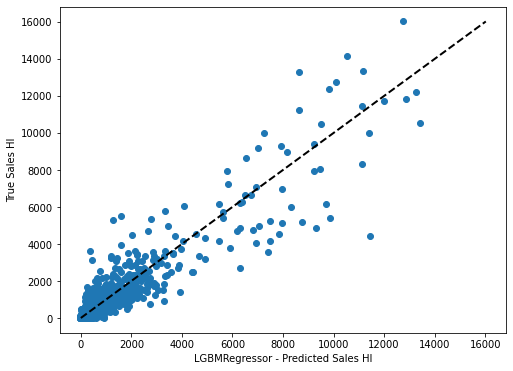

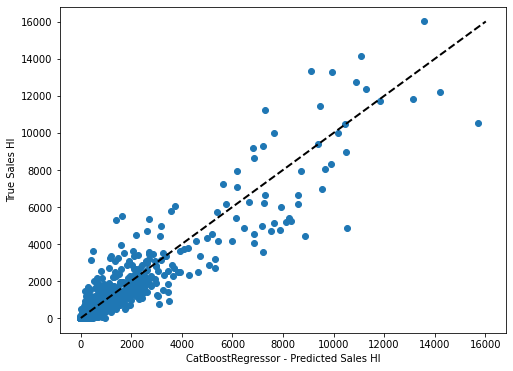

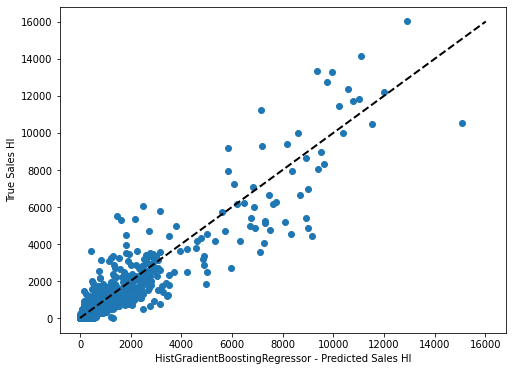

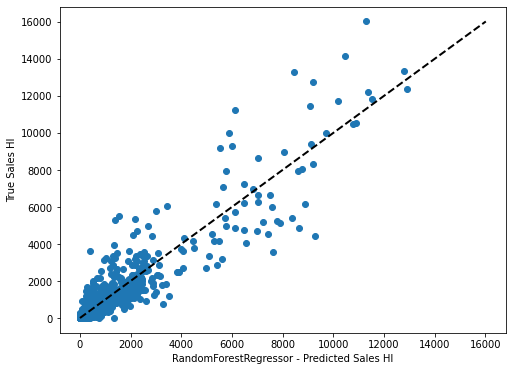

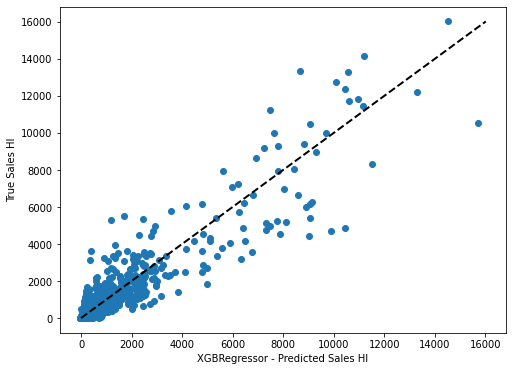

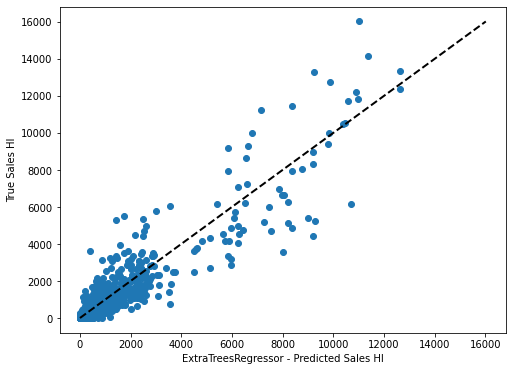

In [314]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl")

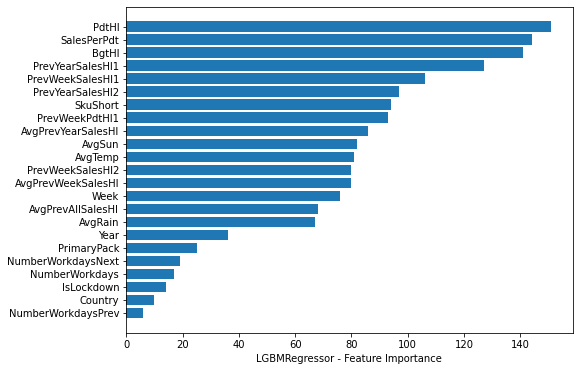

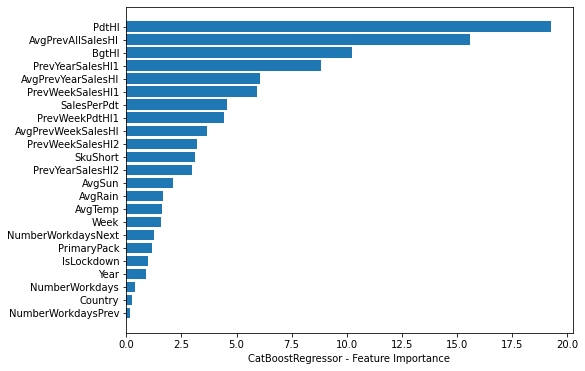

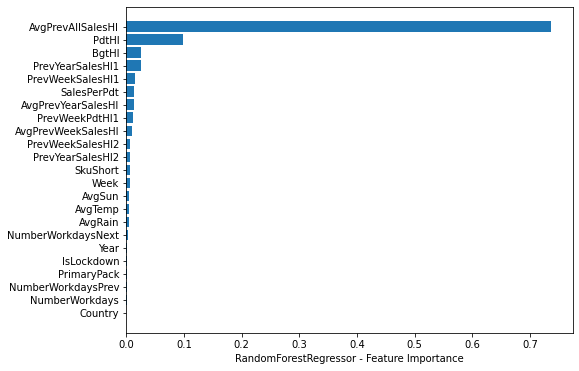

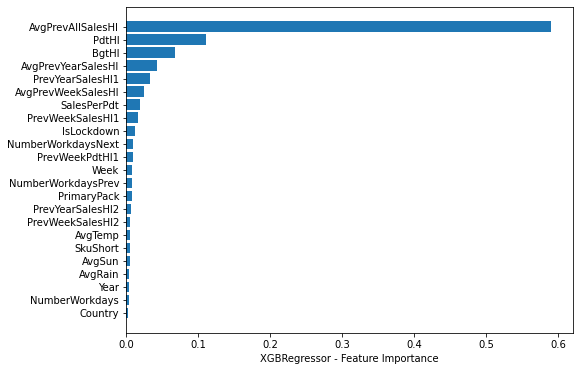

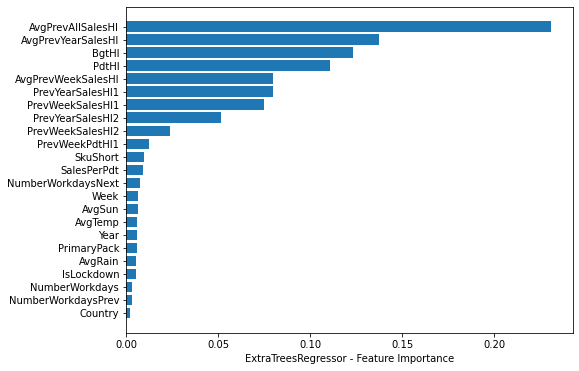

In [315]:
for key, model in estimators:
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(8,6))
        sorted_idx = model.feature_importances_.argsort()
        plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
        plt.xlabel(f"{key} - Feature Importance")
        plt.show()
    else:
        f"{key} - NOT FOUND Feature Importance"

### VotingRegressor

In [316]:
model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



off-trade
Coefficient of determination: 0.8681
Maximum residual error: 5112.0000
Mean absolute percentage error regression loss: 17951703387059192.0000
Old Coefficient of determination: 0.9544
Old Maximum residual error: 4024.0000
Mean absolute percentage error regression loss: 334373986254886.6875


## Model analysis

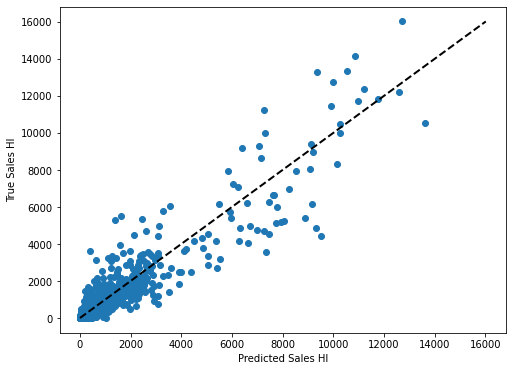

In [317]:
# plt.figure(figsize=(8,6))
# plt.scatter(y_test, y_pred)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# plt.xlabel("Predicted Sales Hl")
# plt.ylabel("True Sales Hl")

# plt.show()

show_pred(y_test, y_pred, "Predicted Sales Hl")

In [318]:
plt.figure(figsize=(8,6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

AttributeError: 'VotingRegressor' object has no attribute 'feature_importances_'

In [ ]:
result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

In [ ]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# X_labels = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_labels)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [ ]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()
X_labels = X.columns.tolist()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

In [ ]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [ ]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [ ]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [ ]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [ ]:
# shap.plots.force(shap_values[0])

In [ ]:
# shap.plots.force(shap_values)

In [ ]:
# shap.plots.scatter(shap_values, color=shap_values)

In [ ]:
# shap.plots.bar(shap_values)

In [ ]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [ ]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [ ]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

## Use model

In [ ]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363